In [1]:
%load_ext watermark
%watermark -u -d -m -v -p numpy,matplotlib,iris,sattools,umtools,faamtools,pyveccalc

last updated: 2016-08-17 

CPython 3.5.2
IPython 5.0.0

numpy 1.10.4
matplotlib 1.5.2
iris 1.9.2
sattools 0.1
umtools 0.1.5
faamtools 0.2.3
pyveccalc 0.2.8

compiler   : GCC 4.8.2 20140120 (Red Hat 4.8.2-15)
system     : Linux
release    : 3.13.0-93-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit


In [2]:
%matplotlib inline

In [4]:
import datetime
import iris
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from mpl_toolkits.axes_grid1 import AxesGrid
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
import numpy as np
import os
import string
#
import umtools.irismode as umi
import umtools.utils as umu
#
import map_plot_func as mymap
import mypaths
import phys_meteo as met
import misc_utils as misc

In [5]:
mpl.rcParams['mathtext.default'] = 'regular'
mpl.rcParams['font.family'] = 'sans-serif'

In [6]:
uchar_list = list(string.ascii_uppercase)
lchar_list = list(string.ascii_lowercase)

In [7]:
pe = [PathEffects.withStroke(linewidth=2, foreground='w')]

In [8]:
fmt = 'pdf'
svfigkw = dict(dpi=300, bbox_inches='tight', format=fmt)

In [9]:
imgname = os.path.join('figures', 'ds_vs_um_{var1}_{var2}_{zztop}m.{fmt}') # http://i.imgur.com/Z8BEMn9.gif

In [10]:
c_p = iris.cube.Cube(1004.5, long_name='air_heat_capacity_at_constant_pressure', units='J kg-1 K-1')
R_d = iris.cube.Cube(287.04, long_name='specific_gas_constant_for_dry_air', units='J kg-1 K-1')
g = iris.cube.Cube(9.8, long_name='gravity_acceleration', units='m s-2')
p0 = iris.cube.Cube(1e5, long_name='reference_air_pressure', units='Pa')

In [11]:
def calculate_initial_compass_bearing(lon_lat_1, lon_lat_2):
    """
    Calculates the bearing between two points.
    The formulae used is the following:
        angle = atan2(sin(delta long).cos(lat2),
                cos(lat1).sin(lat2) − sin(lat1).cos(lat2).cos(delta long))
    :Parameters:
      - `pointA: The tuple representing the latitude/longitude for the
        first point. Latitude and longitude must be in decimal degrees
      - `pointB: The tuple representing the latitude/longitude for the
        second point. Latitude and longitude must be in decimal degrees
    :Returns:
      The bearing in degrees
    :Returns Type:
      float
    """
    if (type(lon_lat_1) != tuple) or (type(lon_lat_2) != tuple):
        raise TypeError("Only tuples are supported as arguments")

    lat1 = np.radians(lon_lat_1[1])
    lat2 = np.radians(lon_lat_2[1])

    dlon = np.radians(lon_lat_2[0] - lon_lat_1[0])

    x = np.sin(dlon) * np.cos(lat2)
    y = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(dlon)

    initial_bearing = np.arctan2(x, y)

    # Now we have the initial bearing but np.arctan2 return values
    # from -180 to +180 which is not what we want for a compass bearing
    # The solution is to normalize the initial bearing as shown below
    initial_bearing = np.degrees(initial_bearing)
    compass_bearing = (initial_bearing + 360) % 360

    return compass_bearing

In [12]:
def rotate_vector2d(u, v, angle):
    angle = np.deg2rad(angle)
    rot_mat = np.array([[np.cos(angle), -np.sin(angle)], 
                        [np.sin(angle),  np.cos(angle)]])
    vec_mat = np.rollaxis(np.array([u, v]), 1, 0)
    u_rot, v_rot = np.rollaxis(rot_mat @ vec_mat, 1, 0)
    
    return u_rot, v_rot

In [13]:
def show_dropsonde_symbols(ax, x, y, txt, colour='m'):
    ax.plot(x, y, linestyle='None', marker='v', ms=25, mec=colour, mfc=colour, zorder=123)
    an = ax.annotate('{}'.format(txt), (x, y), size=10, ha='center', va='center', color='w',
                      path_effects=[PathEffects.withStroke(linewidth=2,  foreground='k')])
    an.set_zorder(200)

## Load UM data

In [14]:
iris.FUTURE.netcdf_promote = True
iris.FUTURE.cell_datetime_objects = True
um_res = umu.grdstep('km2p2')
fcst_init = '25_1200'

In [15]:
fcst_init_dt = datetime.datetime.strptime('201303'+fcst_init, '%Y%m%d_%H%M')

In [16]:
rem_aux_kw = dict(time_var_name='time', remove_fcst_period=True)

#### 4D arrays, cropped area, $\theta$-levels

In [17]:
def cleaner(cube, field, filename):
    try:
        cube.coord('time').var_name = 'time'
    except:
        pass
    for i_auxcoord in cube.aux_coords:
        if i_auxcoord.name() == u'forecast_period':
            cube.remove_coord(i_auxcoord)

In [18]:
files_wildcard = os.path.join(mypaths.extdir, 'UM', 'exp_results', um_res.key, fcst_init, 'obs', 'processed', 'umnsa_t*-proc*nc')

In [19]:
f_thetalev = iris.load(files_wildcard, callback=cleaner).concatenate()

In [20]:
theta = f_thetalev.extract('air_potential_temperature', strict=True)
pres = f_thetalev.extract('air_pressure', strict=True)
gh = f_thetalev.extract('geopotential_height', strict=True)
cimixr = f_thetalev.extract('mass_fraction_of_cloud_ice_in_air', strict=True)
cwmixr = f_thetalev.extract('mass_fraction_of_cloud_liquid_water_in_air', strict=True)
qc = f_thetalev.extract('CLOUD WATER CONTENT (qc)', strict=True)
qt = f_thetalev.extract('TOTAL SPECIFIC HUMIDITY (qT)', strict=True)
thtacoords = umi.get_model_real_coords(theta)

In [21]:
z = pres.coord('atmosphere_hybrid_height_coordinate').points

In [22]:
airtemp = theta * ( (pres / p0) ** (R_d /c_p).data )
airtemp.rename('air_temperature')

In [63]:
mixr = qt / (-1 * qt + 1)

In [66]:
mixr.rename('mixing_ratio')

In [72]:
theta_e = theta.copy()
theta_e.data = met.calc_theta_e(airtemp.data, pres.data, mixr.data)
theta_e.rename('pseudo_equivalent_potential_temperature')

In [85]:
misc.minmax(mixr.data)

array([  3.64663898e-06,   5.16239840e-03])

#### 4D arrays, cropped area, $\rho$-levels

In [23]:
files_wildcard = os.path.join(mypaths.extdir, 'UM', 'exp_results', um_res.key, fcst_init, 'obs', 'processed', 'umnsa_r*-proc*nc')

In [24]:
f_rholev = iris.load(files_wildcard, callback=cleaner).concatenate()

In [25]:
w = f_rholev.extract('upward_air_velocity', strict=True)
rhocoords = umi.get_model_real_coords(w, dims='tzyx')
u = f_rholev.extract('x_wind', strict=True)
v = f_rholev.extract('y_wind', strict=True)
u, v = umi.unrotate_uv(u, v)

## Airborne data

### Dropsondes

In [26]:
from faamtools.avaps import read_avaps_nc

In [27]:
AB = range(0,11)
ds = [read_avaps_nc(mypaths.ds_flist[ind], time2datetime=True) for ind in AB]

In [28]:
filt_kw = dict(cutoff=1/50, sample_rate=1, order=6)

## Vertical cross-sections

In [29]:
def two_crossect(dataset, ds_list, ds_id, ds_var_name, zname,
                 zz=None, xstep=1, returnx=False, model_coords=None, filt_kw=None):

    leg_dist, leg_grid = misc.get_leggrid(ds_id, ds_list, xstep)
    ds_cross = misc.ds_cross_sect(leg_grid, zz, leg_dist, ds_id, ds_list, zname, ds_var_name, filt_kw)

    model_data = []
    for i in ds_id:
        ds_zpoints = getattr(ds_list[i],zname).fil[:]
        ds_coord = (ds_list[i].time.fil[:], ds_zpoints, ds_list[i].lat.fil[:], ds_list[i].lon.fil[:])
        res = umi.regrid_model_to_obs(dataset, ds_coord, model_coords=model_coords)
        model_data.append(dict(coord=ds_zpoints, fld=res))

    model_cross = misc.generic_cross_sect(leg_grid, zz, leg_dist, model_data)

    if returnx:
        return ds_cross, model_cross, leg_grid
    else:
        return ds_cross, model_cross

In [30]:
zz = np.arange(0,4010,10)

### Wind velocity

In [31]:
v.coord('atmosphere_hybrid_height_coordinate').var_name = u.coord('atmosphere_hybrid_height_coordinate').var_name
v.coord('surface_altitude').var_name = u.coord('surface_altitude').var_name

In [32]:
u.remove_coord(u.coord('surface_altitude'))
v.remove_coord(v.coord('surface_altitude'))

In [33]:
um_wspd = (u**2 + v**2)**0.5
um_wspd.rename('wind_speed')

In [34]:
vrbls =[
        dict(ds_name='wspd', um_cube=um_wspd, conkw=dict(levels=np.linspace(3,27,9), cmap=plt.cm.Oranges), units='$m$ $s^{-1}$'),
        dict(ds_name='thta', um_cube=w, conkw=dict(levels=np.concatenate([np.arange(-0.5,0,0.1), np.arange(0.1,0.6,0.1)]), colors='b')),
       ]
#np.concatenate([np.arange(-0.5,0,0.05), np.arange(0.1,0.55,0.05)])
aux_vrbls =  [       dict(ds_name='u', um_cube=u),
        dict(ds_name='v', um_cube=v)]

In [35]:
legs = [
        dict(ds_id=range(6), label='AB'),
        dict(ds_id=range(5,11), label='BC')
       ]

#### Prepare data

In [36]:
for leg in legs:
    for ivar in vrbls:
        leg['obs_'+ivar['ds_name']], leg['um_'+ivar['ds_name']], leg['xx'] = two_crossect(ivar['um_cube'], ds, leg['ds_id'], ivar['ds_name'], 
                                                                                          'hgt', zz=zz, xstep=1, returnx=True, filt_kw=filt_kw)
        if 'transfunc' in ivar:
            leg['um_'+ivar['ds_name']] = ivar['transfunc'](leg['um_'+ivar['ds_name']])

In [37]:
plot_tangential_wind = True

In [38]:
if plot_tangential_wind:
    for leg in legs:
        for ivar in aux_vrbls:
            _, leg['um_'+ivar['ds_name']], _ = two_crossect(ivar['um_cube'], ds, leg['ds_id'], ivar['ds_name'], 
                                                            'hgt', zz=zz, xstep=1, returnx=True, filt_kw=filt_kw)
        idx_beg, idx_end = leg['ds_id'][0], leg['ds_id'][-1]
        angle = calculate_initial_compass_bearing((ds[idx_beg].lon.fil.mean(), ds[idx_beg].lat.fil.mean()),
                                                  (ds[idx_end].lon.fil.mean(), ds[idx_end].lat.fil.mean()))
        print(idx_beg, idx_end, angle)

        angle += -90 # if 0, use v-component
        
        leg['um_u_rot'], leg['um_v_rot'] = rotate_vector2d(leg['um_u'], leg['um_v'], angle)

0 5 320.18853707
5 10 161.047066805


In [39]:
# xsub = slice(None, None, 20)
# zsub = slice(None, None, 40)

In [40]:
# i = 1
# # plt.contour(leg['xx'], zz, leg['um_u'], colors='k')
# plt.contour(legs[i]['xx'], zz, legs[i]['um_wspd'], colors='k')
# x2d, z2d = np.meshgrid(legs[i]['xx'], zz)
# plt.quiver(x2d[zsub, xsub], z2d[zsub, xsub], legs[i]['um_u_rot'][zsub, xsub], 0*legs[i]['um_thta'][zsub, xsub], **quiv_kw)
# # plt.quiver(x2d[zsub, xsub], z2d[zsub, xsub], legs[i]['um_v_rot'][zsub, xsub], 0*legs[i]['um_thta'][zsub, xsub], color='b')

In [41]:
# print(misc.minmax(legs[i]['um_u_rot'][:40,100:150]))
# print(misc.minmax(legs[i]['um_v_rot'][:40,100:150]))

In [42]:
# a = u.extract(iris.Constraint(atmosphere_hybrid_height_coordinate=lambda x: 270 < x.point < 300))\
# .extract(iris.Constraint(time=umu.nearest_tval(u, ds[-1].time.fil[-1])))
# b = v.extract(iris.Constraint(atmosphere_hybrid_height_coordinate=lambda x: 270 < x.point < 300))\
# .extract(iris.Constraint(time=umu.nearest_tval(u, ds[-1].time.fil[-1])))
# a2 = u.extract(iris.Constraint(atmosphere_hybrid_height_coordinate=lambda x: 3200 < x.point < 3500))\
# .extract(iris.Constraint(time=umu.nearest_tval(u, ds[-1].time.fil[-1])))
# b2 = v.extract(iris.Constraint(atmosphere_hybrid_height_coordinate=lambda x: 3200 < x.point < 3500))\
# .extract(iris.Constraint(time=umu.nearest_tval(u, ds[-1].time.fil[-1])))

In [43]:
# xsub = slice(100, -100, 10)
# ysub = slice(120, -100, 10)

In [44]:
# plt.figure(figsize=(15, 8))
# plt.plot((ds[0].lon.fil.mean(), ds[5].lon.fil.mean()),
#          (ds[0].lat.fil.mean(), ds[5].lat.fil.mean()))
# plt.plot((ds[5].lon.fil.mean(), ds[10].lon.fil.mean()),
#          (ds[5].lat.fil.mean(), ds[10].lat.fil.mean()))

# plt.quiver(lons[ysub, xsub], lats[ysub, xsub], a.data[ysub, xsub], b.data[ysub, xsub])
# print('at {:.0f}m'.format(a.coord('atmosphere_hybrid_height_coordinate').points[0]))
# plt.quiver(lons[ysub, xsub], lats[ysub, xsub], a2.data[ysub, xsub], b2.data[ysub, xsub], color='r')
# print('at {:.0f}m'.format(a2.coord('atmosphere_hybrid_height_coordinate').points[0]))

In [45]:
ncols = len(legs)
nrows = 2

In [46]:
quiv_kw = dict(color='#333333', scale=250, width=0.005)
zwind_scale = 20

In [47]:
xsub = slice(None, None, 10)
zsub = slice(None, None, 30)

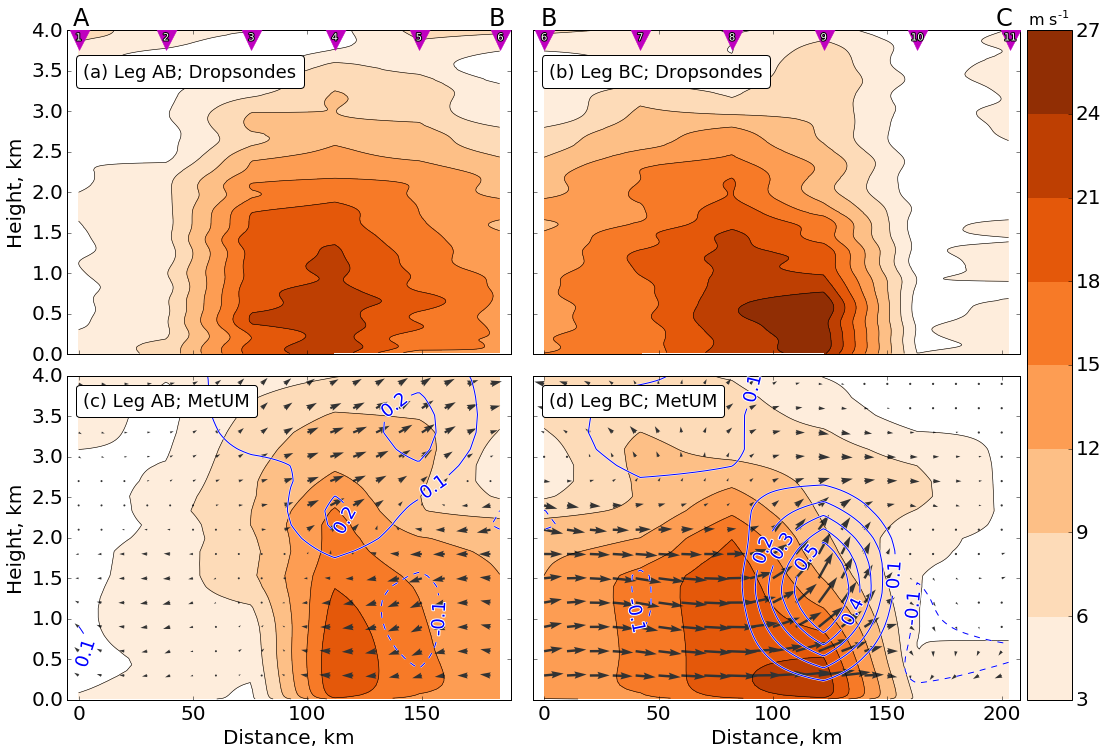

In [48]:
fig = plt.figure(figsize=(9*ncols,6*nrows))
axgr = AxesGrid(fig, 111, nrows_ncols=(nrows, ncols), axes_pad=0.3, aspect=False,
                cbar_location='right', cbar_mode='single', cbar_pad=0.1)

iter_lchar_list = iter(lchar_list)
for ii, (leg, axc) in enumerate(zip(legs, axgr.axes_column)):
    leg_dist, leg_grid = misc.get_leggrid(leg['ds_id'], ds, 1)
    iax = axc[0]
    # Dropsondes
    iax.set_xlim(leg['xx'][0]-5, leg['xx'][-1]+5)
    for k, iAB in enumerate(leg['ds_id']):
        show_dropsonde_symbols(iax, leg_dist[k], zz[-10], '{}'.format(iAB+1))
    for loc, xbox, letter in zip((4, 3), (0.05, 0.95), leg['label']):
        at = AnchoredText('{0}'.format(letter), 
                          prop=dict(size=24, color='k'), 
                          frameon=False, 
                          loc=loc,
                          bbox_to_anchor=(xbox, 1.0),
                          bbox_transform=iax.transAxes,
                          borderpad=0., pad=0)
        iax.add_artist(at)
    for ivar in vrbls:
        if 'cmap' in ivar['conkw']:
            cblevs = ivar['conkw']['levels']
            cb_units = ivar['units']
            c = iax.contourf(leg['xx'], zz, leg['obs_'+ivar['ds_name']], **ivar['conkw'])
            _ = iax.contour(leg['xx'], zz, leg['obs_'+ivar['ds_name']], ivar['conkw']['levels'], linewidths=0.6, colors='k')
        else:
            cc = iax.contour(leg['xx'], zz, leg['obs_'+ivar['ds_name']], **ivar['conkw'])
            clbls = iax.clabel(cc, inline=True, inline_spacing=30, fmt='%3.0f', fontsize=20, colors=ivar['conkw']['colors'])
            plt.setp(cc.collections, path_effects=pe)
            plt.setp(clbls, path_effects=pe)
    
    # MetUM
    iax = axc[1]
    iax.set_xlim(leg['xx'][0]-5, leg['xx'][-1]+5)
    for ivar in vrbls:
        if 'cmap' in ivar['conkw']:
            c = iax.contourf(leg['xx'], zz, leg['um_'+ivar['ds_name']], **ivar['conkw'])
            _ = iax.contour(leg['xx'], zz, leg['um_'+ivar['ds_name']], ivar['conkw']['levels'], linewidths=0.6, colors='k')
        else:
            cc = iax.contour(leg['xx'], zz, leg['um_'+ivar['ds_name']], **ivar['conkw'])
            clbls = iax.clabel(cc, inline=True, inline_spacing=30, fmt='%2.1f', fontsize=18, colors=ivar['conkw']['colors'])
            plt.setp(cc.collections, path_effects=pe)
            plt.setp(clbls, path_effects=pe)
    if plot_tangential_wind:
        x2d, z2d = np.meshgrid(leg['xx'], zz)
        q = iax.quiver(x2d[zsub, xsub], z2d[zsub, xsub],
                       leg['um_u_rot'][zsub, xsub], zwind_scale*leg['um_thta'][zsub, xsub],
                       **quiv_kw)
#         if ii == 1:
#             qk = iax.quiverkey(q, 0.9, -0.05, 5, r'5 $m$ $s^{-1}$', labelpos='S',
#                                fontproperties={'size': 14})

cb = plt.colorbar(c, cax=axgr.cbar_axes[0], ticks=cblevs)
cb.ax.tick_params(labelsize=20)
cb.ax.set_title(cb_units, fontsize=16)

for iax, name, leglab in zip(np.array(axgr.axes_row).flatten(), ['Dropsondes']*2+['MetUM']*2, [leg['label'] for leg in legs]*2):
    txt = '({lab}) Leg {leg}; {name}'.format(lab=next(iter_lchar_list), leg=leglab, name=name)
    if name == 'Dropsondes':
        add_at_kw = dict(bbox_to_anchor=(0., 0.95), bbox_transform=iax.transAxes)
    else:
        add_at_kw = {}
    at = AnchoredText(txt, prop=dict(size=18), frameon=True, loc=2, **add_at_kw)
    at.patch.set_boxstyle('round', pad=0., rounding_size=0.2)
    at.set_zorder(400)
    iax.add_artist(at)

    iax.set_xlabel('Distance, km', fontsize=20)
    iax.set_yticklabels(iax.get_yticks()[:]/1e3)
    iax.set_ylabel('Height, km', fontsize=20)
    iax.tick_params(axis='both', which='major', labelsize=20)
        
fig.savefig(imgname.format(var1=vrbls[0]['ds_name'], var2=vrbls[1]['ds_name'], zztop=zz[-1], fmt=fmt), **svfigkw)

### Temperature and water vapour mixing ratio

In [49]:
sh2mixr_gkg = lambda x: met.spechum2mixr(x)*1e3

In [79]:
vrbls =[
        dict(ds_name='mixr', um_cube=qt, transfunc=sh2mixr_gkg, conkw=dict(levels=[1e-2, 1e-1, 5e-1, 1, 1.5, 2, 3], cmap=plt.cm.PuBuGn), units='$g$ $kg^{-1}$'),
        dict(ds_name='thte', um_cube=theta_e, conkw=dict(levels=np.arange(260,279,1), colors='b')),
        dict(ds_name='thta', um_cube=theta, conkw=dict(levels=np.arange(260,279,1), colors='r')),
       ]

In [80]:
legs = [
        dict(ds_id=range(6), label='AB'),
        dict(ds_id=range(5,11), label='BC')
       ]

#### Prepare data

In [81]:
for leg in legs:
    for ivar in vrbls:
        leg['obs_'+ivar['ds_name']], leg['um_'+ivar['ds_name']], leg['xx'] = two_crossect(ivar['um_cube'], ds, leg['ds_id'], ivar['ds_name'], 
                                                                                          'hgt', zz=zz, xstep=1, returnx=True)
        if 'transfunc' in ivar:
            leg['um_'+ivar['ds_name']] = ivar['transfunc'](leg['um_'+ivar['ds_name']])

In [82]:
ncols = len(legs)
nrows = 2

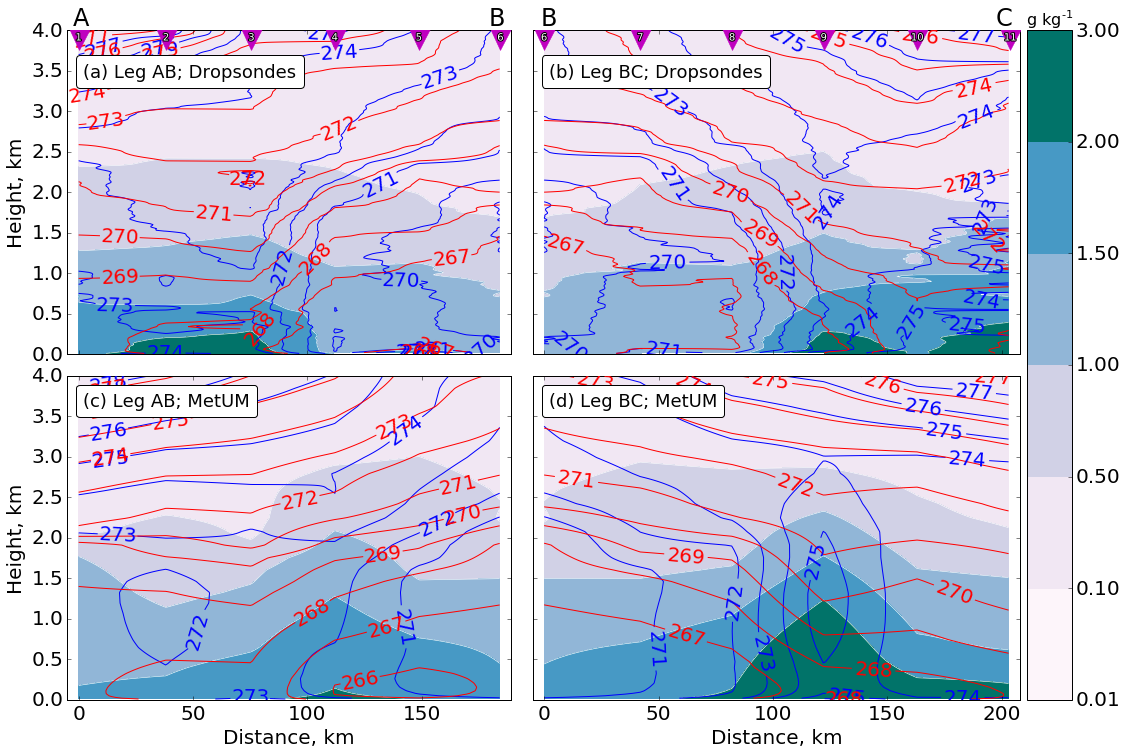

In [83]:
fig = plt.figure(figsize=(9*ncols,6*nrows))
axgr = AxesGrid(fig, 111, nrows_ncols=(nrows, ncols), axes_pad=0.3, aspect=False,
                cbar_location='right', cbar_mode='single', cbar_pad=0.1)

iter_lchar_list = iter(lchar_list)
for leg, axc in zip(legs, axgr.axes_column):
    leg_dist, leg_grid = misc.get_leggrid(leg['ds_id'], ds, 1)
    iax = axc[0]
    # Dropsondes
    iax.set_xlim(leg['xx'][0]-5, leg['xx'][-1]+5)
    for k, iAB in enumerate(leg['ds_id']):
        show_dropsonde_symbols(iax, leg_dist[k], zz[-10], '{}'.format(iAB+1))
    for loc, xbox, letter in zip((4, 3), (0.05, 0.95), leg['label']):
        at = AnchoredText('{0}'.format(letter), 
                          prop=dict(size=24, color='k'), 
                          frameon=False, 
                          loc=loc,
                          bbox_to_anchor=(xbox, 1.0),
                          bbox_transform=iax.transAxes,
                          borderpad=0., pad=0)
        iax.add_artist(at)
#         iax.annotate('{0}'.format(letter), xy=(xbox, zz[-1]+1), xycoords='data')
    for ivar in vrbls:
        if 'cmap' in ivar['conkw']:
            cblevs = ivar['conkw']['levels']
            cb_units = ivar['units']
            c = iax.contourf(leg['xx'], zz, leg['obs_'+ivar['ds_name']], **ivar['conkw'])
            _ = iax.contour(leg['xx'], zz, leg['obs_'+ivar['ds_name']], ivar['conkw']['levels'], linewidths=0.6, colors='w')
        else:
            cc = iax.contour(leg['xx'], zz, leg['obs_'+ivar['ds_name']], **ivar['conkw'])
            clbls = iax.clabel(cc, inline=True, inline_spacing=30, fmt='%3.0f', fontsize=20, colors=ivar['conkw']['colors'])
#             plt.setp(cc.collections, path_effects=pe)
#             plt.setp(clbls, path_effects=pe)
    
    # MetUM
    iax = axc[1]
    iax.set_xlim(leg['xx'][0]-5, leg['xx'][-1]+5)
    for ivar in vrbls:
        if 'cmap' in ivar['conkw']:
            c = iax.contourf(leg['xx'], zz, leg['um_'+ivar['ds_name']], **ivar['conkw'])
            _ = iax.contour(leg['xx'], zz, leg['um_'+ivar['ds_name']], ivar['conkw']['levels'], linewidths=0.6, colors='w')
        else:
            cc = iax.contour(leg['xx'], zz, leg['um_'+ivar['ds_name']], **ivar['conkw'])
            clbls = iax.clabel(cc, inline=True, inline_spacing=30, fmt='%3.0f', fontsize=20, colors=ivar['conkw']['colors'])
#             plt.setp(cc.collections, path_effects=pe)
#             plt.setp(clbls, path_effects=pe)
            

cb = plt.colorbar(c, cax=axgr.cbar_axes[0], ticks=cblevs)
cb.ax.tick_params(labelsize=20)
cb.ax.set_title(cb_units, fontsize=16)

for iax, name, leg in zip(np.array(axgr.axes_row).flatten(), ['Dropsondes']*2+['MetUM']*2,[leg['label'] for leg in legs]*2):
    txt = '({lab}) Leg {leg}; {name}'.format(lab=next(iter_lchar_list), leg=leg, name=name)
    if name == 'Dropsondes':
        add_at_kw = dict(bbox_to_anchor=(0., 0.95), bbox_transform=iax.transAxes)
    else:
        add_at_kw = {}
    at = AnchoredText(txt, prop=dict(size=18), frameon=True, loc=2, **add_at_kw)
    at.patch.set_boxstyle('round', pad=0., rounding_size=0.2)
    at.set_zorder(400)
    iax.add_artist(at)
    
    iax.set_xlabel('Distance, km', fontsize=20)
#     iax.set_yticks([1000,2000,3000,4000])
    iax.set_yticklabels(iax.get_yticks()[:]/1e3)
    iax.set_ylabel('Height, km', fontsize=20)
    iax.tick_params(axis='both', which='major', labelsize=20)
    
fig.savefig(imgname.format(var1=vrbls[0]['ds_name'], var2=vrbls[1]['ds_name'], zztop=zz[-1], fmt=fmt), **svfigkw)

### Additional plot: drift of the dropsondes

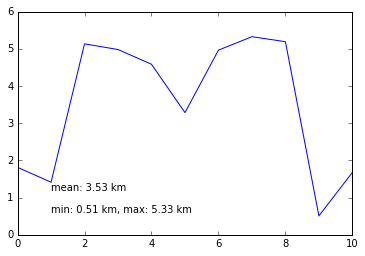

In [55]:
drifts = []
for i, ids, in enumerate(ds):
    dslat0 = np.min(ids.lat.fil) #[0]
    dslon0 = np.min(ids.lon.fil) #[0]
    dslat = np.max(ids.lat.fil) #[-1]
    dslon = np.max(ids.lon.fil) #[-1]
    drifts.append(met.r_earth/1e3*np.arccos(np.sin(np.radians(dslat0))
                                      * np.sin(np.radians(dslat))
                                      + np.cos(np.radians(dslat0))
                                      * np.cos(np.radians(dslat))
                                      * np.cos(np.radians(dslon0-dslon))))
plt.plot(drifts)
plt.annotate('mean: {:.2f} km'.format(np.mean(drifts)), (0.1, 0.2), xycoords='axes fraction')
plt.annotate('min: {:.2f} km, max: {:.2f} km'.format(*misc.minmax(drifts)), (0.1, 0.1), xycoords='axes fraction')